# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

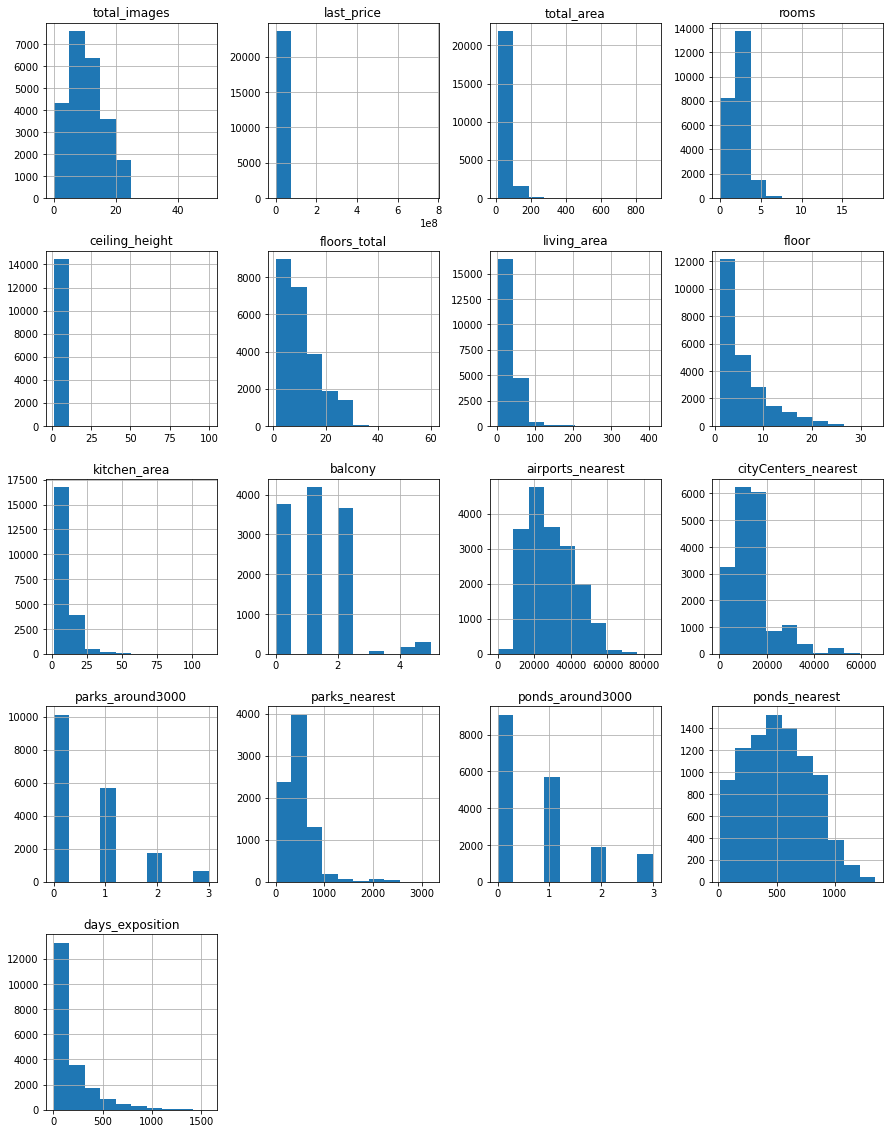

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.hist(figsize=(15, 20))
plt.show();

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Предобработка данных

**ОБРАБОТКА ПРОПУСКОВ**

In [3]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [4]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [5]:
data['floors_total'].isna().sum()

86

In [6]:
data.dropna(subset=['floors_total'], inplace=True)

In [7]:
for room in data['rooms'].unique():
    data.loc[(data['rooms'] == room) & (data['living_area'].isna()), 'living_area'] = data.loc[data['rooms'] == room, 'living_area'].median()

data['is_apartment'].value_counts()
    

False    2725
True       50
Name: is_apartment, dtype: int64

<div class="alert alert-info"> В столбце 'living_area', которое также является количественным значением, мы также заменим пропуски медианным значением, в зависимости от количества комнат в квартире. 

В столбце 'is_apartment' 20924 пропуска из 23698 значений, возможно, в выборке большинство квартир, а не апартаментов (судя по соотношению имеющихся значений) и продавцы просто пропускали это поле при заполнении данных, поэтому многие остались пустыми. Возможно, была ошибка при выгрузке. Пока, есть смысл заменить пропуски на False.

In [8]:
data['is_apartment'] = data['is_apartment'].fillna(False)

In [9]:
data.loc[data['kitchen_area'].isna()]['rooms'].value_counts()

1    812
2    643
3    426
0    194
4     97
5     40
6      8
7      7
8      3
9      1
Name: rooms, dtype: int64

<div class="alert alert-info"> В столбце 'kitchen_area' продавец, скорее всего, не указал значения. Большинство пропусков среди квартир с 1-3 комнатами. Попробуем заменить пропуски по аналогии с жилой площадью - ориентируясь на количество комнат в квартире. Нужно убедиться, что медиана площади кухни в категориях 1-3-комнатных квартир правдободобна и не подвержена влиянию выбросов. 

In [10]:
data.loc[data.loc[:, 'rooms'] == 1]['kitchen_area'].describe()


count    7203.000000
mean        9.548692
std         3.311765
min         1.300000
25%         7.200000
50%         9.000000
75%        11.000000
max        58.400000
Name: kitchen_area, dtype: float64

In [11]:
data.loc[data.loc[:,'rooms'] == 1]['kitchen_area'].median()

9.0

In [12]:
data.loc[data.loc[:,'rooms'] == 2]['kitchen_area'].describe()

count    7270.000000
mean        9.974912
std         5.118034
min         2.000000
25%         7.000000
50%         8.700000
75%        11.300000
max        93.000000
Name: kitchen_area, dtype: float64

In [13]:
data.loc[data.loc[:,'rooms'] == 2]['kitchen_area'].median()

8.7

In [14]:
data.loc[data.loc[:,'rooms'] == 3]['kitchen_area'].describe()

count    5369.000000
mean       11.293906
std         6.904164
min         4.000000
25%         7.000000
50%         9.500000
75%        13.000000
max       107.000000
Name: kitchen_area, dtype: float64

In [15]:
data.loc[data.loc[:,'rooms'] == 3]['kitchen_area'].median()

9.5

<div class="alert alert-info"> После числового описания данных и вычисления медианы по категориям можно увидеть, что во всех трёх случаях 75% значений (минимум) находятся близко друг к другу и среднее значение почти не подвержено влиянию аномальных значения, соотвественно медиану можем использовать для заполнения пропусков в столбце. 

In [16]:
import warnings 

warnings.filterwarnings('ignore') 

for room in data['rooms'].unique():
    data.loc[(data['rooms'] == room) & (data['kitchen_area'].isna()), 'kitchen_area'] = data.loc[data['rooms'] == room, 'kitchen_area'].median()


In [17]:
data['kitchen_area'].isna().sum()

194

<div class="alert alert-info"> Часть пропусков заменим медианами в зависимости от общей площади квартиры, остальные удалим.

In [18]:
import warnings 

warnings.filterwarnings('ignore')

for area in data['total_area'].unique():
    data.loc[(data['total_area'] == area) & (data['kitchen_area'].isna()), 'kitchen_area'] = data.loc[data['total_area'] == area, 'kitchen_area'].median()
    
data.loc[data['kitchen_area'].isna()]

data = data.loc[~data['kitchen_area'].isna()] 

<div class="alert alert-info"> Пропусков в столбце 'balcony' больше 11000, вероятно, продавец их не указал. Это может повлиять на рассчёты, но среднее количество балконов сложно рассчитать, т.к. это целое число, к тому же, в постройках разного времени разные планировки и количество балконов для разных квартир. Поэтому заменим пропуски на 0. 

In [19]:
data['balcony'] = data['balcony'].fillna(0)

data = data.dropna(subset=['locality_name'])

<div class="alert alert-info"> В столбце 'locality_name' всего 49 пропусков и по данным из таблицы сложно определить, к какой локации можно отнести квартиры с пропущенными локациями. В некоторых случаях, это объясняет пропуски в столбцах с картографическими данными. Их не много, поэтому удалим эти строки. 

In [20]:
data.loc[(data['airports_nearest'].isna()) & (data['cityCenters_nearest'].isna()) & (data['parks_around3000'].isna()) & (data['ponds_around3000'].isna()) & (data['ponds_nearest'].isna()) & (data['parks_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,False,...,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,...,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.00,5,False,...,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,False,...,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9.0,17.60,2,False,...,9.00,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,False,...,5.50,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.65,5.0,17.50,4,False,...,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5.0,38.00,4,False,...,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3.0,29.70,1,False,...,8.70,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-info"> Сделав срез по 6 столбцам airports_nearest,	cityCenters_nearest, parks_around3000, ponds_around3000, ponds_nearest, parks_nearest, убедились, что многие пропуски в них совпадают (5482 строк), это значит, что с помощью данных из таблицы мы эти пропуски заполнить не сможем. Скорее всего, произошла ошибка при выгрузке данных или программа не смогла рассчитать значения, т.к. это картографические данные. 

<div class="alert alert-info"> Также, в таблицы нет данных, которые могли бы помочь нам восстановить количество дней в столбце days_exposition, поэтому эти пропуски мы также оставим.

**ИЗМЕНЕНИЕ ТИПОВ ДАННЫХ**

<div class="alert alert-info"> Переведём в удобный формат datetime данные в столбце 'first_day_exposition'. 

Не может быть дробного вещественного значения количества этажей, поэтому переводим float в int. Тоже самое и со значениями количества балконов в столбце 'balcony'.

In [21]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M:%S')

In [22]:
data['floors_total'] = data['floors_total'].astype(int)

data['balcony'] = data['balcony'].astype(int)

data['last_price'] = data['last_price'].astype(int)

**ОБРАБОТКА УНИКАЛЬНЫХ ЗНАЧЕНИЙ**

In [23]:
types = ['городской поселок ', 'посёлок городского типа ','поселок городского типа ','городской посёлок ', 'коттеджный посёлок ',
         'коттеджный поселок ','посёлок при железнодорожной станции ','посёлок станции ', 'поселок ','посёлок ', ' ']

for typ in types:
    data['locality_name'] = data['locality_name'].str.replace(typ, '')

<div class="alert alert-info"> В столбце 'locality_name' удаляем все категории посёлков, т.к. почти все неявные дубликаты в таблице связаны именно с чередованием букв е/ё в слове "посёлок". Также, удалим пробелы на названиях, они не сильно повлияют на восприятие данных, но уберут большое количество дубликатов с пробелом в начале. 

**ОБРАБОТКА РЕДКИХ И ВЫБИВАЮЩИХСЯ ЗНАЧЕНИЙ**

In [24]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23533.000000,2.353300e+04,23533.000000,23533.000000,23533.000000,23533.000000,23533.000000,23533.000000,23533.000000,23533.000000,18027.000000,18050.000000,18051.000000,8025.000000,18051.000000,9025.000000,20362.000000
mean,9.881995,6.542702e+06,60.356665,2.073471,2.724520,10.669570,34.347493,5.875834,10.436510,0.593507,28802.022300,14195.109474,0.611656,490.536075,0.769099,518.220166,180.899420
std,5.681879,1.090923e+07,35.599693,1.076616,0.991667,6.592432,21.726512,4.870109,5.652758,0.960805,12632.831819,8614.984777,0.802134,341.548152,0.938544,277.950831,219.791319
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.425000e+06,40.000000,1.000000,2.600000,5.000000,18.400000,2.000000,7.300000,0.000000,18573.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.300000,4.000000,9.000000,0.000000,26757.000000,13098.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.800000e+06,69.750000,3.000000,2.700000,16.000000,42.700000,8.000000,11.500000,1.000000,37274.000000,16291.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


(0.0, 5.0)

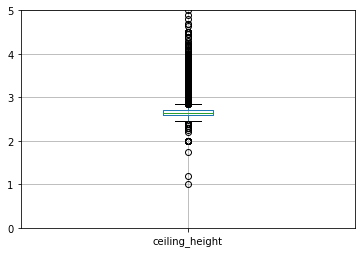

In [25]:
data.boxplot('ceiling_height')
plt.ylim(0, 5)

<div class="alert alert-info" 
     
     Изучив распределение значений в столбцe ceiling_height, видим, что диапазон типичных значений очень узок, между 2,4 и 2,8. Минимально допустимая высота потолка - 2,1м. Также учтём, что есть старые постройки и элитные квартиры, где потолки могу превышать 3, 4 и более метра. Для надёжности оставим максимальное значение - 10м (возможно, лофты) и уберём все ниже 2,1м.

In [26]:
data.loc[data['ceiling_height'] > 11, 'ceiling_height'] = data['ceiling_height']/10

data = data.query('2.1 < ceiling_height < 11')

In [27]:
data.loc[(data['balcony'] > 2) & (data['rooms'] < 2)].sort_values(by='total_area')

data = data.loc[~((data['balcony'] > 2) & (data['rooms'] < 2))]

data = data.loc[~((data['balcony'] > 3) & (data['rooms'] < 3))]

data = data.loc[~((data['balcony'] > 4) & (data['rooms'] < 4))]

data = data.loc[data['living_area'] < data['total_area']]

data.duplicated().sum()

0

<div class="alert alert-info" 
     
Изучив гистограмму по всему датафрейму, можно увидеть, что во многих столбцах есть аномально большие значения, влияющие на отображение распределения значений. Но метод describe() показывает, что не везде эти выбросы влияют на среднее/медианное значение (last_price, total_area, rooms, ceiling_height, living_area, balcony, floors_total - в этих столбцах 75% значений близко к среднему значению). 

В столбце ceiling_height мы разделим значения больше 11м на 10, т.к. вероятнее всего это результат ошибки при внесении значения. Также, уберём все значения больше 11м и менее 2.1м. 

Также, удаляем строки, где количество балконов превышает количество комнат вместе с кухней.  

Также, есть квартиры, где общая площадь меньше жилой площадии (29 строк), удалим их.

### Посчитайте и добавьте в таблицу новые столбцы

In [28]:
data['square_meter_price'] = data['last_price']/data['total_area']

In [29]:
data['publication_weekday'] = data['first_day_exposition'].dt.weekday

data['publication_month'] = data['first_day_exposition'].dt.month

data['publication_year'] = data['first_day_exposition'].dt.year

def floor_type(row):
    if row['floor']==1:
        return 'первый'
    elif row['floor']==row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

data['cityCenter_km'] = data['cityCenters_nearest']/1000

data['cityCenter_km'] = data['cityCenter_km'].round()

### Проведите исследовательский анализ данных

**ИЗУЧЕНИЕ ПАРАМЕТРОВ ОБЪЕКТОВ**

In [30]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,publication_weekday,publication_month,publication_year,cityCenter_km
count,23134.000000,2.313400e+04,23134.00000,23134.000000,23134.000000,23134.000000,23134.000000,23134.000000,23134.000000,23134.000000,...,17749.000000,7893.000000,17749.000000,8883.000000,20032.000000,2.313400e+04,23134.000000,23134.000000,23134.000000,17748.000000
mean,9.871272,6.532038e+06,60.23279,2.068168,2.698456,10.634261,34.265357,5.849269,10.411428,0.530518,...,0.613161,489.563284,0.769959,518.374423,181.175120,9.933590e+04,2.566914,6.401617,2017.367684,14.177259
std,5.673347,1.098340e+07,35.75917,1.079463,0.238082,6.584127,21.820691,4.853864,5.652546,0.815542,...,0.804188,341.159304,0.938729,277.573187,220.151481,5.032933e+04,1.785859,3.492608,1.039040,8.641069
min,0.000000,1.219000e+04,12.00000,0.000000,2.200000,1.000000,2.000000,1.000000,1.300000,0.000000,...,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.00000,1.000000,2.600000,5.000000,18.300000,2.000000,7.200000,0.000000,...,0.000000,287.000000,0.000000,294.000000,45.000000,7.656626e+04,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.600000e+06,52.00000,2.000000,2.650000,9.000000,30.155000,4.000000,9.000000,0.000000,...,0.000000,454.000000,1.000000,503.000000,96.000000,9.493671e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.740000e+06,69.20000,3.000000,2.700000,16.000000,42.500000,8.000000,11.400000,1.000000,...,1.000000,612.000000,1.000000,728.000000,232.000000,1.140793e+05,4.000000,10.000000,2018.000000,16.000000
max,50.000000,7.630000e+08,900.00000,19.000000,10.300000,60.000000,409.700000,33.000000,112.000000,5.000000,...,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.907500e+06,6.000000,12.000000,2019.000000,66.000000


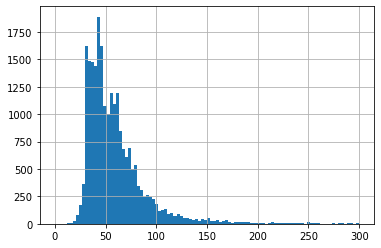

In [31]:
import matplotlib.pyplot as plt
data['total_area'].hist(bins=100, range=(0, 300))
plt.show()

<div class="alert alert-info" В столбце total_area есть редкие большие значения, которые влияют на общий график распределения значений. Чтобы лучше отобразить значения, мы увеличим количество корзин до 100 и сократим диапазон до 300 кв.м. 

На второй гистограмме уже лучше видно распределение значений, большинство квартир находится в диапазоне 25-100 кв.м., далее мы видим длинный хвост из редких больших квартир. 

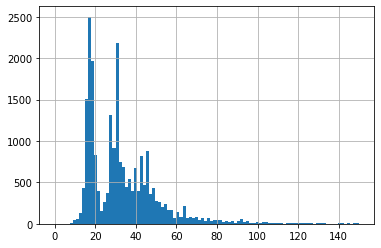

In [32]:
data['living_area'].hist(bins=100, range=(0, 150))
plt.show()

 В столбце living_area мы также увеличили количество корзин и сократили диапазон для наглядности. Здесь можем видеть неоднородное распределение значений, есть пик где-то с 15 до 22 кв.м. и с 30 до 50 кв.м. несколько пиков. Также есть хвост редких больших значений. Основная масса значений в диапазоне от 10 до 60 кв.м. 

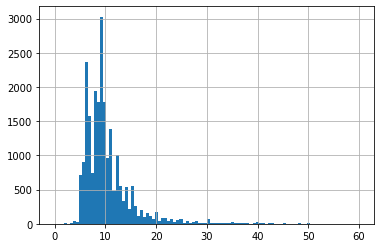

In [33]:
data['kitchen_area'].hist(bins=100, range=(0, 60))
plt.show()

 В столбце kitchen_area пик значений приходится на 9-10 кв.м., есть аномально большие значения более 60 кв.м. Основная масса значений от 5 до 15 кв. м. 

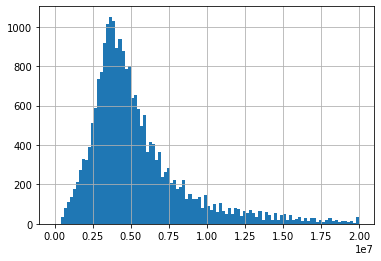

In [34]:
data['last_price'].hist(bins=100, range=(0, 2e7))
plt.show()

В столбце last_price есть аномально большие значения до 700 млн рублей (скорее всего, элитные квартиры в центре), однако, основная масса значений расположена в диапазоне от 1,2 до 10 млн рублей. 

<AxesSubplot:>

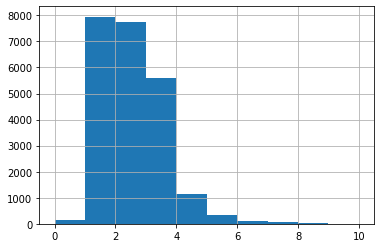

In [35]:
data['rooms'].hist(range=(0, 10))

По гистограмме столбца rooms видно, что значения могут достигать 17 комнат и выше, но больше всего квартир с 1-3 комнатами. Есть квартиры с количеством комнат 0, возможно, это студии, нужно проверить площадь. 

<AxesSubplot:>

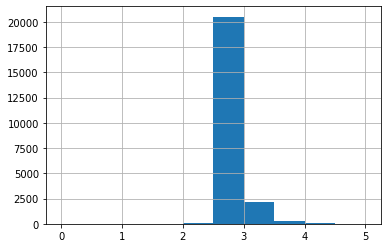

In [36]:
data['ceiling_height'].hist(range=(0, 5))

По гистограмме высоты потолков видим, что почти все квартиры имеют высоту потолка в пределах от 2,5 до 3м. Есть небольшая часть квартир с высотой от 3 до 3,5м и редкие значения более 3,5м. 

<AxesSubplot:>

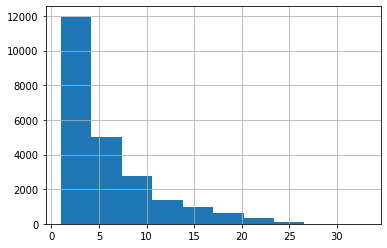

In [37]:
data['floor'].hist()

По данным из столбца floor видим, что больше половины квартир (почти 12000) располагаются с 1 по 4 этаж, четверть квартир находится с 5 по 7 этаж и другая четверть распределена между этажами выше. Максимальные значения достигают 33 этажа. 

<AxesSubplot:>

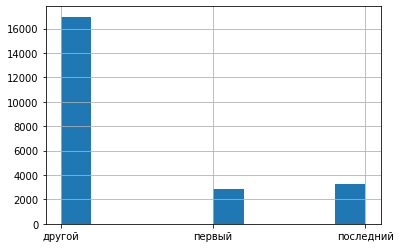

In [38]:
data['floor_type'].hist()

Около 17000 квартир не находятся на первом или последнем этаже. Квартир на первом и последнем этаже примерно одинаковое количество (около 3000).

<AxesSubplot:>

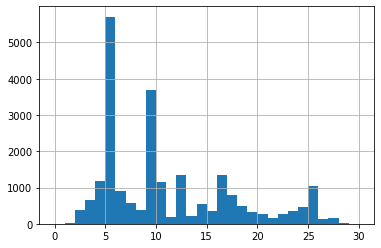

In [39]:
data['floors_total'].hist(bins=30, range=(0, 30))

<AxesSubplot:>

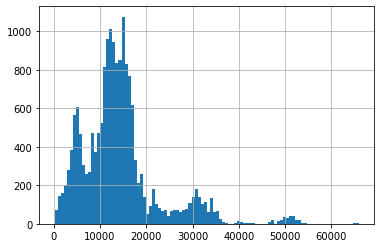

In [40]:
data['cityCenters_nearest'].hist(bins=100)

В столбце cityCenters_nearest есть почти 5000 пропусков, но имеющиеся значения показывают, что основная масса квартир находится от 5 до 20 км от центра города. Есть и квартиры прямо в самом центе города, есть квартиры, где расстояние до центра достигает 60 км и выше. 

<AxesSubplot:>

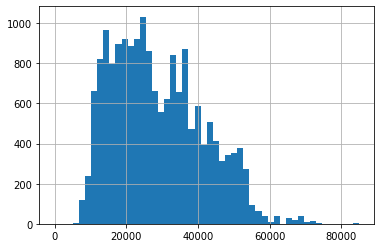

In [41]:
data['airports_nearest'].hist(bins=50)

Есть квартиры, где расстояние до аэропорта - 0 м. Самое большое расстояние 84 км. Большинство квартир расположены в диапазоне от 10 до 50км. На некоторые пики на гистограмме может влиять количество измерений - в столбце 17000 из 23000 строк.

<AxesSubplot:>

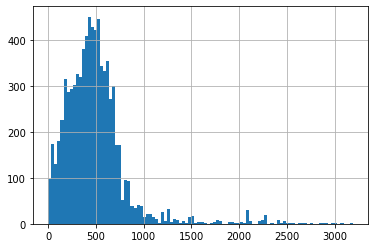

In [42]:
data['parks_nearest'].hist(bins=100)

В столбце ближайших парков видим, что большинство из указанных значений (7882 строки) находятся меньше чем в 800 метрах от парка. Максимальные значения - 3190м.

<AxesSubplot:>

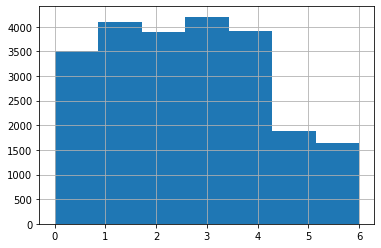

In [43]:
data['publication_weekday'].hist(bins=7)

Построив гистограмму дней недели публикации с количеством корзин, равным количеству дней недели видим, что основная масса публикаций приходится на период с понедельника по пятницу (особенно вторник и четверг), в субботу и воскресенье публикаций в 2 раза меньше. 

<AxesSubplot:>

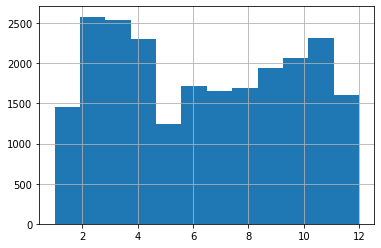

In [44]:
data['publication_month'].hist(bins=12)

Гистрограмму месяца публикации построили по аналогии с днём недели. Количество корзин - 12. Видно, что больше всего объявлений публикуются в начале года (февраль-апрель) и к концу года количество объявлений начинает нарастать (с сентября по ноябрь). 


**СКОРОСТЬ ПРОДАЖИ КВАРТИРЫ**

<AxesSubplot:>

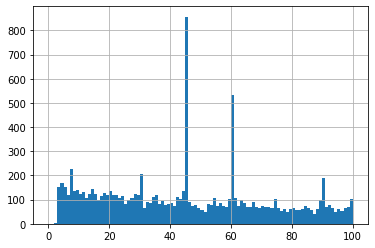

In [45]:
data['days_exposition'].hist(range=(0, 100), bins=100)

<div class="alert alert-info"> <b>Комментарии студента:</b> После увеличения масштаба графика, мы можем увидеть огромный скачок в значении 45, что, скорее всего объясняет медиану в 96 дней, несмотря на очень долгие выбросы до 4 лет и более. 
    
Также видно, более 500 квартир продается за 60 дней. 
    
При рассчёте медианы на срезе от 45 дней продажи, видим резкие изменения в медианном значений, скачок на 50 дней.

In [46]:
data.loc[data['days_exposition'] > 45]['days_exposition'].median()

146.0

(0.0, 400.0)

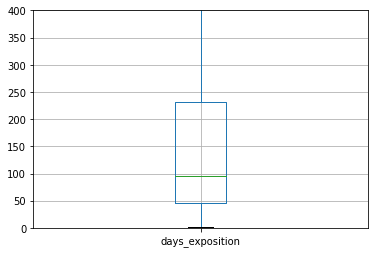

In [47]:
data.boxplot('days_exposition')
plt.ylim(0,400)

In [48]:
data['days_exposition'].median()

96.0

В столбце days_exposition у нас есть не все данные, только 19987 измерений. Гистограмма показывает, что основная масса квартир продавалась до 250 дней, после в каждой корзине уже менее 50 квартир. Об этом же нам говорит и метод describe(), 75% значений находятся до 232. Есть длинный хвост из значений, достигающих 1580 дней - более 4-х лет. Медианное значение - 96 дней. По распределению значений в квартилях можем видеть, что долгими можно считать продажи от 500 дней и выше(на ящике с усами значения после 500 считаются аномалиями), а слишком короткими - до 45 дней. 

**ИЗУЧЕНИЕ ФАКТОРОВ ВЛИЯНИЯ НА ПОЛНУЮ СТОИМОСТЬ ОБЪЕКТА**

0.6530632166169201

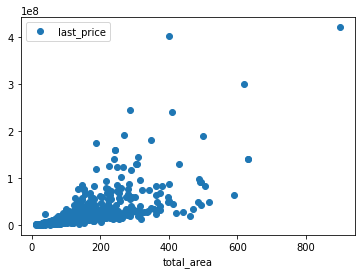

In [49]:
#Зависимость стоимости от общей площади
data.pivot_table(values='last_price', index='total_area', aggfunc='median').plot(style='o')
data['total_area'].corr(data['last_price'])

0.6921799168590855

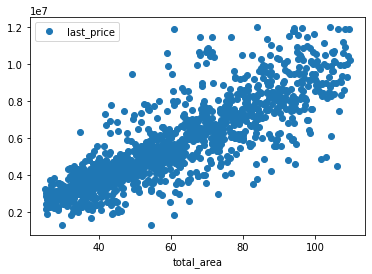

In [50]:
data1 = data.query('25 < total_area < 110 & 1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='total_area', aggfunc='median').plot(style='o')
data1['total_area'].corr(data1['last_price'])

Построили 2 графика, с выбросами и без выбросов в значениях площали и стоимости квартиры, чтобы понять, влияют ли они на наличие взаимосвязи между двумя величинами. Хоть мы и видим разные графики, коэффициент корреляции Пирсона в случае с выбросами всего на 0,04 меньше, чем без выбросов. Это объясняет второй график, где собраны типичные значения. Здесь чётко видно, что увеличением одного значения, увеличивается и второе. Но, всё же, не в 100% случаев, например, квартира площадью 60кв.м. может стоить как 10 млн., так и 2 млн. После 200 кв.м. на первом графике мы уже чётче наблюдаем хаотичное распределение значений, что логично, т.к. в датасете с выбросами коэффициент корреляции ниже. 

0.5579135974471153

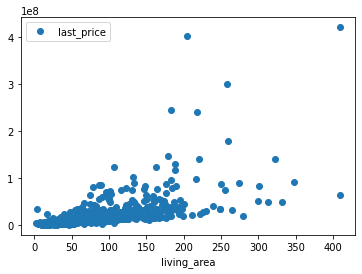

In [51]:
#Зависимость стоимости от жилой площади

data.pivot_table(values='last_price', index='living_area', aggfunc='median').plot(style='o')

data['living_area'].corr(data['last_price'])

0.5649163238458312

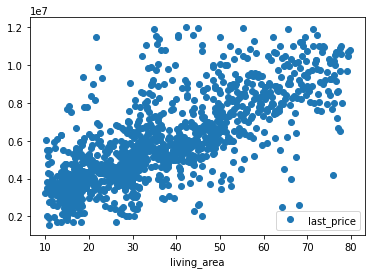

In [52]:
data1 = data.query('10 < living_area < 80 & 1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='living_area', aggfunc='median').plot(style='o')
data1['living_area'].corr(data1['last_price'])

Ориентируясь на describe() и hist() для столбца living_area, также построили фильтрованный график. Жилая площадь и цена уже менее связаны между собой. Как полные данные, так и фильтрованные дают коэффициент 0.55, значит есть выбивающиеся значения, это видно на обоих графиках. 

0.45431527987568726

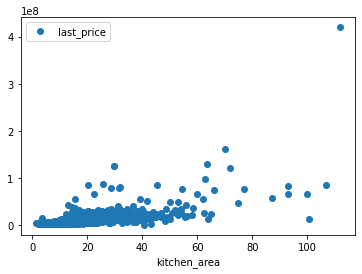

In [53]:
#Зависимость стоимости от площади кухни

data.pivot_table(values='last_price', index='kitchen_area', aggfunc='median').plot(style='o')

data['kitchen_area'].corr(data['last_price'])

0.4658784272219671

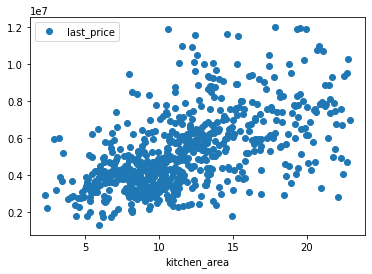

In [54]:
data1 = data.query('2 < kitchen_area < 23 & 1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='kitchen_area', aggfunc='median').plot(style='o')
data1['kitchen_area'].corr(data1['last_price'])

Стоимость и площаль кухни на обоих графиках имеет почти одинаковый коэффициент корреляции, на обоих графиках есть выбивающиеся значения. Зависимость площади кухни меньше влияет на стоимость, чем жилая и общая площадь. Значение менее 0,5 даёт понять, что зависимость подвержена влиянию третьих факторов.

0.36546200240693555

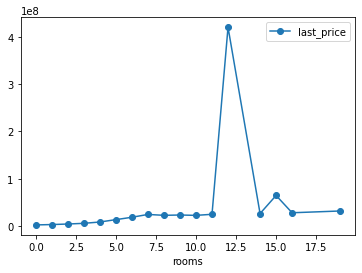

In [55]:
#Зависимость стоимости от количества комнат

data.pivot_table(values='last_price', index='rooms', aggfunc='median').plot(style='o-')

data['rooms'].corr(data['last_price'])

0.45905918919435024

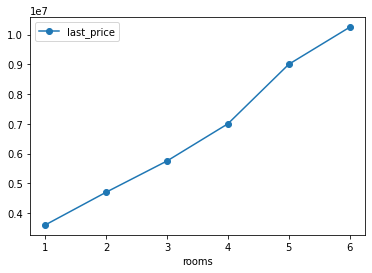

In [56]:
data1 = data.query('0 < rooms < 7 & 1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='rooms', aggfunc='median').plot(style='o-')
data1['rooms'].corr(data1['last_price'])

По графикам связи количества комнат и стоимости видим, что есть очень слабая связь на полном графике и чуть более сильную зависимость на фильрованном графике. Это объясняется выбросами в больших элитных квартирах, где больше 10 комнат и стоимость более 400 млн. В целом видно, что зависимость подвержена влиянию других факторов (возможно, удалённости от центра или населённого пункта). 

<AxesSubplot:xlabel='floor_type_number'>

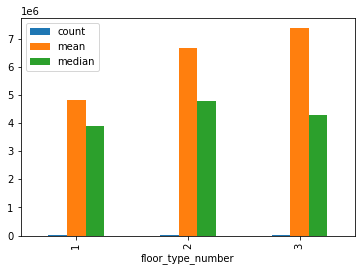

In [57]:
#Зависимость стоимости от типа этажа 
def floor_type_number(row):
    if row['floor_type']=='первый':
        return 1
    elif row['floor_type']=='последний':
        return 3
    else:
        return 2
    
data['floor_type_number'] = data.apply(floor_type_number, axis=1)

data.pivot_table(values='last_price', index='floor_type_number', aggfunc=('mean', 'median', 'count')).plot(kind='bar')

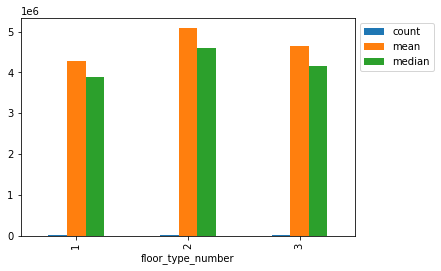

In [58]:
data1 = data.query('1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='floor_type_number', aggfunc=('mean', 'median', 'count')).plot(kind='bar')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

<a id='tables'></a> Свобдные таблицы обоих датасетов показывают, что квартиры на первом этаже чаще дешевле, в случае с квартирами на последнем этаже, видно, что в первом датасете безусловно влияют на статистику цены элитных квартир в 35-этажных домах современных жилых комплексов. Но в фильтрованных данных и в медианном значении в первом датасете видим, что квартиры на последних этажах чаще дешевле. Если взглянуть на гистограмму столбца floors_total можно увидеть, что в выборке много пятиэтажных домов. Последние этажи в таких домак ценятся редко, т.к. в них нет лифта. Но данную гипотезу стоит проверить. 

Можно сказать, что есть зависимость в случае с первым этажом, в остальном, стоить учитывать другие факторы.

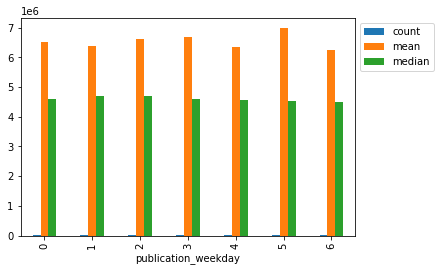

In [59]:
#Зависимость стоимости от дня недели публикаци

data.pivot_table(values='last_price', index=('publication_weekday'), aggfunc=('mean', 'median', 'count')).plot(kind='bar')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

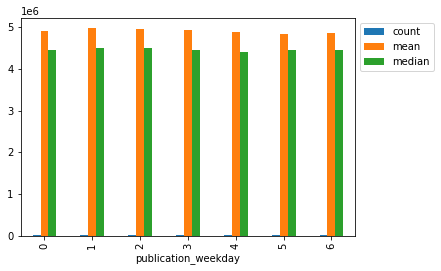

In [60]:
data1 = data.query('1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='publication_weekday', aggfunc=('mean', 'median', 'count')).plot(kind='bar')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

По таблицам связи дня недели публикации и стоимости не найдено каких-либо закономерности по стоимости. Есть разница между случайными днями недели, но она совсем небольшая. 

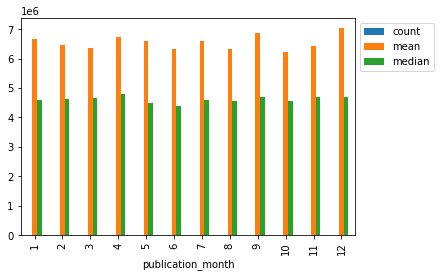

In [61]:
#Зависимость стоимости от месяца публикации

data.pivot_table(values='last_price', index=('publication_month'), aggfunc=('mean', 'median', 'count')).plot(kind='bar')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

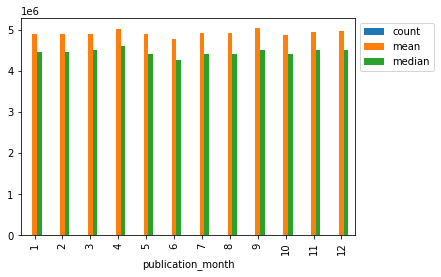

In [62]:
data1 = data.query('1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='publication_month', aggfunc=('mean', 'median', 'count')).plot(kind='bar')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

Стоимость квартир очень незначительно варьируется, но нет какой-либо зависимости стоимости от месяца публикации.

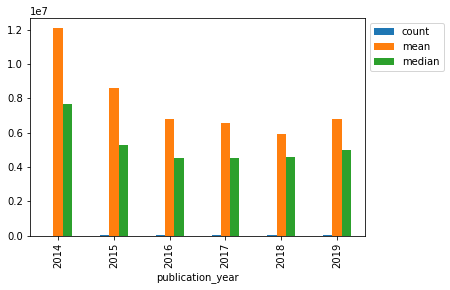

In [63]:
#Зависимость стоимости от года публикации
data.pivot_table(values='last_price', index=('publication_year'), aggfunc=('mean', 'median', 'count')).plot(kind='bar')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

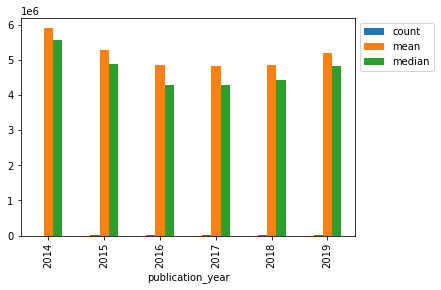

In [64]:
data1 = data.query('1200000 < last_price < 12000000')
data1.pivot_table(values='last_price', index='publication_year', aggfunc=('mean', 'median', 'count')).plot(kind='bar')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

В таблицах взаимосвязи года публикации и стоимости сложно установить какие-либо закономерности, т.к. в 2014 и 2019 годах мы видим неполные данные, они ограничены выборкой (с ноября 2014 по март 2019). В 2015 году стоимость была выше, возможно, из-за малого количества квартир, выставленных на продажу (маленькое предложение - большой спрос). Но в следующих 2016-2018 количество объявлений растёт, но стоимость остаётся одинаковой. В 2019 ценник выше, но данных мало и этим показателям нельзя доверять на 100%. Поэтому сложно сказать, что стоимость зависит от года публикации. 


**СРЕДНЯЯ ЦЕНА КВАДРАТНОГО МЕТРА В 10 ПОПУЛЯРНЫХ ГОРОДАХ**

In [65]:
#data.info()
data.pivot_table(index='locality_name', values='square_meter_price', aggfunc=('count', 'median')).sort_values(by='count', ascending=False).head(10)

,count,median
locality_name,,
Санкт-Петербург,15370,104656.662476
Мурино,565,86075.949367
Шушары,433,77049.180328
Всеволожск,385,65789.473684
Пушкин,369,100000.000000
Колпино,330,74562.809676
Парголово,327,91642.857143
Гатчина,298,67671.510409
деревняКудрово,290,92044.864227


Самое большое количество объявлений и самый дорогой квадратный метр в Санкт-Петербурге(104656 руб.). Самым дешёвым в десятке популярных городов стал город Гатчина(67671 руб.). 


**СРЕДНЯЯ ЦЕНА ЖИЛЬЯ ПО УДАЛЁННОСТИ ОТ ЦЕНТРА**

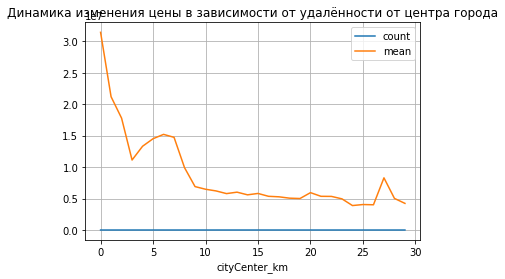

In [66]:
data.query('locality_name == "Санкт-Петербург"')\
    .pivot_table(index='cityCenter_km', values='last_price', aggfunc=('count', 'mean'))\
    .plot(grid = True, title = 'Динамика изменения цены в зависимости от удалённости от центра города');

In [67]:
data.loc[(data['cityCenter_km'] == 3) & (data['last_price'] < 12000000) & (data['floors_total'] > 5)].sort_values(by='floors_total')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,publication_weekday,publication_month,publication_year,floor_type,cityCenter_km,floor_type_number
316,11,5650000,46.3,2017-03-13,2,2.65,6,28.80,2,False,...,0.0,NaN,89.0,122030.237581,0,3,2017,другой,3.0,2
10917,20,10000000,62.3,2019-05-03,2,2.65,6,20.00,3,False,...,0.0,NaN,NaN,160513.643660,4,5,2019,другой,3.0,2
10948,16,10450000,65.6,2019-03-25,3,2.70,6,38.80,5,False,...,1.0,322.0,NaN,159298.780488,0,3,2019,другой,3.0,2
11913,10,6500000,55.8,2017-11-07,2,3.20,6,33.40,4,False,...,0.0,NaN,60.0,116487.455197,1,11,2017,другой,3.0,2
22634,18,8900000,67.8,2017-12-15,2,3.00,6,29.55,5,False,...,1.0,970.0,249.0,131268.436578,4,12,2017,другой,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15426,19,5000000,60.2,2017-08-17,2,2.65,7,27.80,1,False,...,0.0,NaN,35.0,83056.478405,3,8,2017,первый,3.0,1
15404,4,8000000,98.4,2018-07-20,3,3.00,7,45.00,2,False,...,1.0,743.0,60.0,81300.813008,4,7,2018,другой,3.0,2
18999,19,8090000,55.3,2017-11-23,2,2.65,8,31.00,2,False,...,1.0,534.0,144.0,146292.947559,3,11,2017,другой,3.0,2
8145,20,10900000,56.0,2018-02-26,1,3.00,8,24.00,3,False,...,2.0,383.0,133.0,194642.857143,0,2,2018,другой,3.0,2


Видна общая тенденция снижения стоимости жилья дальше от центра города. Но есть провал на 3км, большинство домов в этом проваде 5-7 этажей, возможно, это старый район в центре города, где квартиры дешевле. Есть скачок на 27км, что вероятно является отдалённым районом с элитной недвижимостью. 

### Общий вывод

Было проведено исследование данных о продажах квартир в Санкт-Петербурге и области с ноября 2014 года по март 2019 года. Были исследованы различные факторы, которые могли бы влиять на её конечную стоимость. Результат исследования поможет создать алгоритм для оценки стоимости квартиры в зависимости от различных факторов и предотвратить мошенничество.

В выборке были представлены квартиры разных классовых категорий, присутсвует элитная недвижимость. 

1. Данные были проанализированы и очищены от аномальных значений:
- квартиры с потолками выше 10 метров
- квартиры, где количество балконок превышает количество комнат+кухня
- квартиры, где общая площадь меньше жилой площади

2. Были проанализированы и установлены типичные и редкие значения для следующих параметров жилья: 
- общая площадь (типичные от 25 до 100 кв.м.);
- жилая площадь (типичные от 10 до 60 кв.м.);
- площадь кухни (типичные от 5 до 15 кв.м.);
- цена объекта (типичные от 1,2 млн до 12 млн);
- количество комнат (типичные от 1 до 3);
- высота потолков (типичные от 2,5 до 3м);
- этаж квартиры (типичные от 1 до 7 этажа);
- тип этажа квартиры («первый», «последний», «другой») - большинство квартир располагаются на категории "другой";
- общее количество этажей в доме (типичные 5 и 9 этажей);
- расстояние до центра города (основная масса значений от 5 до 20 км);
- расстояние до ближайшего аэропорта (типичный диапазон от 10 до 50 км);
- расстояние до ближайшего парка(большинство значений до 800 метров);
- день и месяц публикации объявления (объявления чаще выкладывают с понедельника по пятницу, рост можно наблюдать с февраля по апрель, спад летом и тенденция на повышение с сентябя по ноябрь).

3. Были исследованы следующие критерии, влияющие на конечную стоимость квартиры: 
- размер общей площади
- размер жилой площади
- размер площади кухни
- количество комнат
- тип этажа (первый, последний, другой)
- дата размещения

4. По результатам исследования были выявлены следующие показатели зависимости конечной стоимости от критериев выше (1 - прямая зависимость, 0 - нет зависимости): 

- размер общей площади: 0.65
- размер жилой площади: 0.55
- размер площади кухни: 0.45
- количество комнат: 0.4

Тип этажа также имеет связь с конечной стоимостью. Исследование показало, что жильё на первом этаже дешевле, как минимум на 7%. В случае с последним этажом, также видна тенденция снижения цены на 8-9%, однако, стоит учитывать, что в выборке около 6000 пятиэтажных домов, в которых квартиры на последнем этаже чаще дешевле, т.к. в них нет лифта. Стоит также помнить об элитных пентхаусах, которые стоят более 100млн и влияют на общие данные. 

Не было найдено зависимости между датой публикации объявления и конечной стоимостью квартиры.

5. Среди 10 населённых пунктов с самым большим количеством размещённых объявлений самым дорогим стал Санкт-Петербург - 15352 объявления, 104656 рублей за 1 кв.м. Самым дешёвым - город Гатчина - 293 объявления, 67671 рублей за 1 кв.м. 

6. Было выявлено закономерное снижение средней стоимости жилья с удалением от центра города. Самые дорогие квартиры были в 1-3км от центра, но были также и отдалённые районы 27км с элитной недвижимостью. В центре могли также наблюдать снижение цены со средней в 15 млн до 11 млн, что возможно в районах со старыми постройками.

Рекомендуется учитывать также класс недвижимости, т.к. элитные квартиры выделяются на общем фоне и изменяют общее распределение значений. Год постройки может также влиять на цену квартиры, вероятно, это стало причиной провала цен в 3 км от центра города в зданиях с 5-7 этажами. Стоить проверить эту гипотезу. 

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [X]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод